<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Choose-a-person" data-toc-modified-id="Choose-a-person-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Choose a person</a></span></li><li><span><a href="#Get-starting-image-references" data-toc-modified-id="Get-starting-image-references-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Get starting image references</a></span><ul class="toc-item"><li><span><a href="#If-you-want-to-get-your-examples-from-Google-Image-Search" data-toc-modified-id="If-you-want-to-get-your-examples-from-Google-Image-Search-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>If you want to get your examples from Google Image Search</a></span></li><li><span><a href="#If-your-want-to-load-a-previously-labeled-model-and-dataset" data-toc-modified-id="If-your-want-to-load-a-previously-labeled-model-and-dataset-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>If your want to load a previously labeled model and dataset</a></span></li><li><span><a href="#Alternative-Methods" data-toc-modified-id="Alternative-Methods-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Alternative Methods</a></span></li></ul></li><li><span><a href="#Your-initial-reference-images" data-toc-modified-id="Your-initial-reference-images-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Your initial reference images</a></span></li><li><span><a href="#Now-we-will-build-a-training-set" data-toc-modified-id="Now-we-will-build-a-training-set-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Now we will build a training set</a></span><ul class="toc-item"><li><span><a href="#Getting-negative-examples-(via-sampling)" data-toc-modified-id="Getting-negative-examples-(via-sampling)-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Getting negative examples (via sampling)</a></span></li><li><span><a href="#Getting-positive-examples-(via-k-NN)" data-toc-modified-id="Getting-positive-examples-(via-k-NN)-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Getting positive examples (via k-NN)</a></span></li></ul></li><li><span><a href="#Training-a-Classifier" data-toc-modified-id="Training-a-Classifier-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Training a Classifier</a></span><ul class="toc-item"><li><span><a href="#Training-and-obtaining-predictions-across-the-dataset" data-toc-modified-id="Training-and-obtaining-predictions-across-the-dataset-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Training and obtaining predictions across the dataset</a></span></li><li><span><a href="#Visualize-predictions-and-label-new-examples" data-toc-modified-id="Visualize-predictions-and-label-new-examples-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Visualize predictions and label new examples</a></span></li><li><span><a href="#Check-model-precision" data-toc-modified-id="Check-model-precision-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Check model precision</a></span></li></ul></li><li><span><a href="#Your-current-dataset" data-toc-modified-id="Your-current-dataset-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Your current dataset</a></span></li><li><span><a href="#Saving-your-model" data-toc-modified-id="Saving-your-model-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Saving your model</a></span></li><li><span><a href="#Reset-Notebook" data-toc-modified-id="Reset-Notebook-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Reset Notebook</a></span></li></ul></div>

# Setup

Before we begin, we need to load some dependencies and define some utility functions. 

<b>Run all initialization cells before proceeding.</b>

In [ ]:
%matplotlib inline

print('Loading libraries... Please wait.')

from IPython.display import display, clear_output
from IPython.core.pylabtools import figsize
figsize(12, 5)
import ipywidgets as widgets
import itertools
import io
import os
import sys
import pickle
import PIL.Image
import time
import traceback
import random
import math
import numpy as np
np.warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import urllib.request as request
from sklearn import metrics
from datetime import date
from collections import namedtuple, Counter
from subprocess import check_call

from esper.prelude import *
from esper.widget import *
from esper.plot_util import tile_images
from esper.major_canonical_shows import MAJOR_CANONICAL_SHOWS
from esper import embed_google_images

import esper.face_embeddings as face_embeddings

WIDGET_STYLE_ARGS = {'description_width': 'initial'}

MODEL_DIR = '/app/data/identity_models_v2'
GCS_MODEL_DIR = 'gs://esper/tvnews/face_identity_model_v2'

ReferenceFaces = namedtuple(
    'ReferenceFaces', ['name', 'ids', 'embs', 'imgs'])

def show_reference_imgs(refs):
    tiled_imgs = tile_images(
        [cv2.resize(x, (100, 100)) for x in refs.imgs], 
        cols=10, blank_value=255)
    print('Your reference images for {}.'.format(refs.name))
    plt.figure()
    imshow(tiled_imgs)
    plt.tight_layout()
    plt.show()

def flatten(l):
    return [item for sublist in l for item in sublist]

def split_list(l, idx):
    return l[:idx], l[idx:]

def query_faces(ids):
    faces = Face.objects.filter(id__in=ids)
    return faces.values(
        'id', 'bbox_y1', 'bbox_y2', 'bbox_x1', 'bbox_x2',
        'frame__number', 'frame__video__id', 'frame__video__fps',
        'shot__min_frame', 'shot__max_frame')

def query_sample(qs, n):
    return qs.order_by('?')[:n]

def query_faces_result(faces, expand_bbox=0.05):
    """Replaces qs_to_result"""
    result = []
    for face in faces:
        if (face.get('shot__min_frame') is not None and 
                face.get('shot__max_frame') is not None):
            min_frame = int(
                (face['shot__min_frame'] + 
                 face['shot__max_frame']) / 2)
        else:
            min_frame = face['frame__number']
        face_result = {
            'type': 'flat', 'label': '', 
            'elements': [{
                'objects': [{
                    'id': face['id'],
                    'background': False,
                    'type': 'bbox',
                    'bbox_y1': max(face['bbox_y1'] - expand_bbox, 0),
                    'bbox_y2': min(face['bbox_y2'] + expand_bbox, 1),
                    'bbox_x1': max(face['bbox_x1'] - expand_bbox, 0),
                    'bbox_x2': min(face['bbox_x2'] + expand_bbox, 1),
                }], 
                'min_frame': min_frame,
                'video': face['frame__video__id']
            }]
        }
        result.append(face_result)
    return {'type': 'Face', 'count': 0, 'result': result}

def load_face_img(face):
    return crop(load_frame(face.frame.video, face.frame.number, []), face)

def sort_ids_by_distance(ids, embs):
    dists = face_embeddings.dist(ids, targets=embs)
    return [i for _, i in sorted(zip(dists, ids))]

def sort_faces_by_distance(faces, embs, ascending=False):
    ids = [f['id'] for f in faces]
    id_to_dist = {
        k: v for k, v in zip(ids, face_embeddings.dist(ids, targets=embs))
    }
    order_const = 1 if ascending else -1
    faces.sort(key=lambda x: order_const * id_to_dist[x['id']])
    return faces

def video_ids_with_mentions(phrase):
    from esper.captions import phrase_search
    # lazy import
    result = phrase_search(phrase)
    return {d.id for d in result}

def continue_yn_prompt(msg):
    l = input('{} Continue? (y/N): '.format(msg))
    if l.strip().lower() != 'y':
        raise ValueError('User entered No. This is not an error.') 
        
def bsearch_gte(l, target, key=lambda x: x):
    """Find first index greater than or equal to target"""
    assert len(l) > 0
    i = 0
    j = len(l)
    for k in range(math.ceil(math.log(len(l) + 1, 2)) + 1):
        if i == j:
            return i
        pivot = int((i + j) / 2)
        pivot_value = key(l[pivot])
        if pivot == 0:
            if pivot_value >= target:
                return 0
            assert len(l) == 1
            return 1
        prev_value = key(l[pivot - 1])
        assert pivot_value >= prev_value, 'list is not sorted'
        if target > prev_value and target <= pivot_value:
            return pivot
        elif target <= prev_value:
            j = pivot - 1
        else: # target > pivot_value:
            i = pivot + 1
    assert False, 'Unreachable code. Loop executed {} times'.format(k + 1)

def confirm_selected_faces(name, face_ids):        
    submit_button = widgets.Button(
        layout=widgets.Layout(width='auto'),
        style=WIDGET_STYLE_ARGS,
        description='Confirm selection',
        disabled=False,
        button_style='danger',
        tooltip='Submit labels'
    )
    
    example_faces = query_faces(sorted(face_ids))
    example_selection_widget = esper_widget(
        query_faces_result(example_faces), results_per_page=faces_per_page(),
        crop_bboxes=True, jupyter_keybindings=True, show_inline_metadata=False
    )
    
    def on_submit(b):
        ignored_example_face_idxs = set(example_selection_widget.ignored)
        example_selection_widget.close()
        clear_output()

        ids = {
            f['id'] for i, f in enumerate(example_faces) 
            if i not in ignored_example_face_idxs
        }
        print('You deselected {} and accepted {} faces.'.format(
              len(ignored_example_face_idxs), len(ids)))
        
        imgs = par_for(load_face_img, Face.objects.filter(id__in=face_ids))
        embs = [x for _, x in face_embeddings.get(face_ids)]
        global face_references
        face_references = ReferenceFaces(name=name, ids=ids, imgs=imgs, embs=embs)
    
    submit_button.on_click(on_submit)
    
    display(widgets.HBox([widgets.Label('Controls:'), submit_button]))
    display(example_selection_widget)
    
def load_model_and_examples(name, path=None):
    if path is None: 
        path = os.path.join(MODEL_DIR, '{}.pkl'.format(name.lower().replace(' ', '_')))
    print('Loading model: {}'.format(path))
    with open(path, 'rb') as f:
        model = pickle.load(f)
    assert model['name'] == name, 'Model name does not match {} != {}'.format(model['name'], name)
    
    embs = model['init_embs']
    ids = set(model['init_ids'])
    imgs = model['init_imgs']
    weights = model['weights']
    
    references = ReferenceFaces(
        name=model['name'], ids=ids, imgs=imgs, embs=embs)
    pos_examples = set(model['pos_examples'])
    neg_examples = set(model['neg_examples'])
    print('Done! Loaded {} reference faces; {} positive and {} negative examples'.format(
          len(embs), len(pos_examples), len(neg_examples)))
    return references, pos_examples, neg_examples, weights

def save_model_and_examples(path=None, save_to_gcs=True):
    underscore_name = FACE_REFERENCES.name.lower().replace(' ', '_')
    
    if path is None: 
        if not os.path.exists(MODEL_DIR):
            os.makedirs(MODEL_DIR)
        path = os.path.join(MODEL_DIR, '{}.pkl'.format(underscore_name))
    print('Saving model: {}'.format(path))
    
    if os.path.exists(path):
        continue_yn_prompt('Existing file will be overwritten')
    with open(path, 'wb') as f:
        model = {
            'name': FACE_REFERENCES.name,
            'init_embs': FACE_REFERENCES.embs,
            'init_ids': FACE_REFERENCES.ids,
            'init_imgs': FACE_REFERENCES.imgs,
            'pos_examples': POS_EXAMPLES,
            'neg_examples': NEG_EXAMPLES,
            'weights': WEIGHTS
        }
        pickle.dump(model, f)
        if save_to_gcs:
            gcs_path = os.path.join(GCS_MODEL_DIR, '{}.pkl'.format(underscore_name))
            print('Saving model to GCS: {}'.format(gcs_path))
            check_call(['gsutil', 'cp', f.name, gcs_path])
    print('Done!')
    
def reset_notebook():
    global NAME, FACE_REFERENCES, POS_EXAMPLES, NEG_EXAMPLES, WEIGHTS, PREDICTIONS
    try: del NAME
    except NameError: pass
    try: del FACE_REFERENCES
    except NameError: pass
    try: del POS_EXAMPLES
    except NameError: pass
    try: del NEG_EXAMPLES
    except NameError: pass
    try: del WEIGHTS
    except NameError: pass
    try: del PREDICTIONS
    except NameError: pass
    print('Notebook was reset. Provide a new name to start over.')

def load_and_select_faces_from_images(name, img_dir):
    
    def crop_img(img, bbox):
        height, width, _ = img.shape
        y1 = int(bbox.y1 * height)
        y2 = int(bbox.y2 * height)
        x1 = int(bbox.x1 * width)
        x2 = int(bbox.x2 * width)
        return img[y1:y2, x1:x2, :]
    
    face_bboxes = embed_google_images.detect_faces(img_dir)
    
    cand_imgs = []
    for img_path, bbox in face_bboxes:
        img = cv2.imread(img_path)
        img_crop = crop_img(img, bbox)
        assert img_crop.size > 0, \
            'Bad crop dimensions: {} from {}'.format(
            img_crop.shape, bbox)
        img_crop = cv2.resize(img_crop, (100, 100))
        cand_imgs.append(img_crop)
    
    def img_to_widget(img):
        height, width, _ = img.shape
        f = io.BytesIO()
        PIL.Image.fromarray(img).save(f, 'png')
        return widgets.Image(value=f.getvalue(), height=height,
                             width=width)
    
    def get_img_checkbox():
        img_checkbox = widgets.ToggleButton(
            layout=widgets.Layout(width='auto'),
            value=False,
            description='',
            disabled=False,
            button_style='',
            icon=''
        )
        def on_toggle(b):
            if img_checkbox.value:
                img_checkbox.button_style = 'danger'
                img_checkbox.icon = 'check'
            else:
                img_checkbox.button_style = ''
                img_checkbox.icon = ''
        img_checkbox.observe(on_toggle, names='value')
        return img_checkbox
    
    print('Select reference images below: (default=selected)')
    checkboxes = []
    vboxes = []
    for img_crop in cand_imgs:
        img_widget = img_to_widget(
            cv2.cvtColor(img_crop, cv2.COLOR_BGR2RGB))
        img_checkbox = get_img_checkbox()
        checkboxes.append(img_checkbox)
        vboxes.append(widgets.VBox([img_widget, img_checkbox]))
    
    images_per_row = 8
    for i in range(0, len(vboxes), images_per_row):
        display(widgets.HBox(vboxes[i:i + images_per_row]))
        
    submit_button = widgets.Button(
        layout=widgets.Layout(width='auto'),
        style=WIDGET_STYLE_ARGS,
        description='Confirm selections',
        disabled=False,
        button_style='danger'
    )
    def on_submit(b):
        imgs = [
            x for i, x in enumerate(cand_imgs) 
            if checkboxes[i].value]
        clear_output()
        print('Selected {} faces. Ignored {}.'.format(
              len(imgs), len(cand_imgs) - len(imgs)))
        embs = embed_google_images.embed_images(imgs)
        assert len(imgs) == len(embs)
        global FACE_REFERENCES
        FACE_REFERENCES = ReferenceFaces(
            name=name, ids=set(), embs=embs, imgs=imgs)
    submit_button.on_click(on_submit)
    
    cancel_button = widgets.Button(
        layout=widgets.Layout(width='auto'),
        style=WIDGET_STYLE_ARGS,
        description='Abort selection',
        disabled=False,
        button_style='warning'
    )
    def on_cancel(b):
        clear_output()
        print('Canceled selection. No references images were added.')
    cancel_button.on_click(on_cancel)
    
    display(widgets.HBox([widgets.Label('Controls:'), 
            submit_button, cancel_button]))
    return cand_imgs

def get_google_images(name, n=10, **kwargs):
    img_dir = embed_google_images.fetch_images(name, n=n, force='query_extras' in kwargs, 
                                               **kwargs)
    load_and_select_faces_from_images(name, img_dir)
    
def get_image_urls(name, urls):
    tmp_dir = tempfile.mkdtemp('img_download')
    try:
        for i, url in enumerate(urls):
            tokens = url.split('.')
            if len(tokens) > 1:
                ext = tokens[-1]
            else:
                ext = 'png'
            img_path = os.path.join(tmp_dir, '{}.{}'.format(i, ext))
            request.urlretrieve(url, img_path)
        load_and_select_faces_from_images(name, tmp_dir)
    finally:
        if os.path.exists(tmp_dir):
            shutil.rmtree(tmp_dir)

def get_negative_samples(face_references, k=None):
    start_time = time.time()
    neg_samples = list(set(face_embeddings.sample(k)))
    
    submit_button = widgets.Button(
        layout=widgets.Layout(width='auto'),
        style=WIDGET_STYLE_ARGS,
        description='Confirm selections',
        disabled=False,
        button_style='danger',
    )

    neg_samples_ord = sort_ids_by_distance(
        neg_samples, face_references.embs
    )
    neg_samples_ord_idxs = {
        b: a for a, b in enumerate(neg_samples_ord)
    }
    
    dist_time = time.time()
    print('Computed distances: {:0.4f}s'.format(dist_time - start_time))
    
    neg_samples_faces = list(query_faces(neg_samples_ord))
    neg_samples_faces.sort(key=lambda f: neg_samples_ord_idxs[f['id']])
    neg_samples_id_set = {f['id'] for f in neg_samples_faces}
    neg_samples = list(filter(
        lambda x: x in neg_samples_id_set, neg_samples_ord))
    print('DB query finished: {:0.4f}s'.format(time.time() - start_time))
    
    selection_widget = esper_widget(
        query_faces_result(neg_samples_faces), results_per_page=faces_per_page(),
        crop_bboxes=True, jupyter_keybindings=True, disable_playback=True,
        disable_captions=True, show_inline_metadata=False
    )

    def on_submit(b):
        # Read from the widget, update selections, and commit result
        ignored_idxs = set(selection_widget.ignored)
        selected_idxs = set(selection_widget.selected)
        selection_widget.close()
        clear_output() 
        
        # Add to positive set
        pos_samples = set()
        for i in selected_idxs:
            face_id = neg_samples_faces[i]['id']
            if face_id not in face_references.ids:
                _id, emb = face_embeddings.get([face_id])[0]
                assert _id == face_id
                face_references.ids.add(face_id)
                face_references.embs.append(emb)
            pos_samples.add(face_id)

        # Filter negative set
        neg_samples = {
            f['id'] for _, f in filter(
                lambda x: x[0] not in ignored_idxs and x[0] not in selected_idxs,
                enumerate(neg_samples_faces))
        }
        
        print('You selected {} and ignored {} faces.'.format(
              len(selected_idxs), len(ignored_idxs)))
        
        global NEG_EXAMPLES, POS_EXAMPLES
        NEG_EXAMPLES |= neg_samples
        POS_EXAMPLES |= pos_samples
        print(('Added {} negative samples and {} positive examples of {}. ' + 
               'There are now a total of {} negative examples.').format(
              len(neg_samples), len(selected_idxs), face_references.name, len(NEG_EXAMPLES)))
        
        emb_count = face_embeddings.count()
        p_hat = (len(pos_samples) + 1) / (len(pos_samples) + len(neg_samples) + 2)
        print('\nEstimated true positive count: {} +/- {}'.format(
            int(p_hat * emb_count),
            int(emb_count * 1.96 * math.sqrt(p_hat * (1 - p_hat) / (len(pos_samples) + len(neg_samples) + 2)))
        ))
    submit_button.on_click(on_submit)     
   
    display(widgets.HBox([widgets.Label('Controls:'), submit_button]))
    print('You should select all faces that are {}.'.format(face_references.name))
    display(selection_widget)
    
def get_positive_examples(face_references, k):
    submit_button = widgets.Button(
        layout=widgets.Layout(width='auto'),
        style={'description_width': 'initial'},
        description='Confirm selections',
        disabled=False,
        button_style='danger'
    )

    start_time = time.time()
    # Order by increasing distance, excluding already selected
    pos_samples_and_dists = list(filter(
        lambda x: x[0] not in POS_EXAMPLES, 
        face_embeddings.knn(
            targets=face_references.embs, 
            k=len(POS_EXAMPLES) + k, max_threshold=1.)
    ))
    pos_samples_to_idx = {
        f[0]: i for i, f in enumerate(pos_samples_and_dists)
    }
    knn_time = time.time()
    print('Comuputed k-NN: {:0.4f}s'.format(knn_time - start_time))
    
    pos_samples_faces = list(query_faces(
        [x[0] for x in pos_samples_and_dists]))
    pos_samples_faces.sort(key=lambda f: pos_samples_to_idx[f['id']])
    for p in pos_samples_faces:
        _, p['dist'] = pos_samples_and_dists[pos_samples_to_idx[p['id']]]
    print('DB query finished: {:0.4f}s'.format(time.time() - knn_time))
    
    selection_widget = esper_widget(
        query_faces_result(pos_samples_faces), results_per_page=faces_per_page(),
        crop_bboxes=True, jupyter_keybindings=True, disable_playback=True,
        disable_captions=True, show_inline_metadata=False
    )

    def on_submit(b):
        selected_idxs = selection_widget.selected
        ignored_idxs = set(selection_widget.ignored)
        if len(selected_idxs) == 0:
            selected_idxs = [i for i in range(len(pos_samples_faces)) 
                             if i not in ignored_idxs]
        clear_output()
        
        pos_samples = {pos_samples_faces[i]['id'] for i in selected_idxs}
        neg_samples = {pos_samples_faces[i]['id'] for i in ignored_idxs}
        
        global POS_EXAMPLES, NEG_EXAMPLES
        POS_EXAMPLES |= pos_samples
        NEG_EXAMPLES |= neg_samples
        print('Added {} examples of "{}" and {} non-examples. There are now {} positive examples.'.format(
            len(pos_samples), face_references.name, 
            len(neg_samples), len(POS_EXAMPLES)))      
    submit_button.on_click(on_submit)
    
    display(widgets.HBox([widgets.Label('Controls:'), submit_button]))
    print('You should select all faces that are {}.'.format(face_references.name))
    display(selection_widget)

def load_female_face_ids():
    print('Loading set of female faces', file=sys.stderr)
    FEMALE_FACE_IDS_CACHE = '/tmp/female_face_ids.pkl'
    if os.path.exists(FEMALE_FACE_IDS_CACHE):
        with open(FEMALE_FACE_IDS_CACHE, 'rb') as f:
            ids = pickle.load(f)
    else:
        ids = {
            f['face__id'] for f in 
            FaceGender.objects.filter(gender__name='F').values('face__id')
        }
        with open(FEMALE_FACE_IDS_CACHE, 'wb') as f:
            pickle.dump(ids, f)
    return ids

_female_face_ids = None
def is_female_face_id(face_id):
    global _female_face_ids
    if _female_face_ids is None:
        _female_face_ids = load_female_face_ids()
    return face_id in _female_face_ids

DEFAULT_FACES_PER_PAGE = 50
_faces_per_page_slider = widgets.IntSlider(
    value=DEFAULT_FACES_PER_PAGE,
    style=WIDGET_STYLE_ARGS,
    min=25,
    max=100,
    step=1,
    description='Faces per widget page:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
def faces_per_page():
    try:
        return _faces_per_page_slider.value
    except:
        return DEFAULT_FACES_PER_PAGE

DEFAULT_EMBEDDING_SAMPLE = 10
_embedding_sample_slider = widgets.IntSlider(
    value=DEFAULT_EMBEDDING_SAMPLE,
    style=WIDGET_STYLE_ARGS,
    min=1,
    max=25,
    step=1,
    description='Embedding sample (stride):',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
def embedding_sample():
    try:
        return _embedding_sample_slider.value
    except:
        return DEFAULT_EMBEDDING_SAMPLE

display(_faces_per_page_slider)
display(_embedding_sample_slider)
print('Done!')

Loading libraries... Please wait.


# Choose a person

Please select a person for whom you would like to build a model for. 

<b>Running the cell below will display a prompt.</b>

In [9]:
NAME = input('Enter a name: ').strip()
assert NAME != '', 'Name cannot be the empty string'

Enter a name: Eric Holder


# Get starting image references

In order to train a binary model to identify a person, we need to find some initial visual examples of the target person. We will use these initial example images to build a training set to train the model.

We have provided two options for how to obtain these starting images:
 - Google Image Search
 - Existing model

## If you want to get your examples from Google Image Search

The following code fetches images using Google Image Search. You will be asked to select, from the faces in the results, which faces are your target person.

<b>Click on the checkbox area to toggle an image. Hit the confirm button when done.</b>

In [11]:
get_google_images(NAME, query_extras="Attorney General")
# If the images returned are not satisfactory, rerun the above with extra params:
#     query_extras='' # additional keywords to add to search

Selected 9 faces. Ignored 1.


## If your want to load a previously labeled model and dataset

If you have previously saved a model for the target person, you can load reference images and the coresponeding dataset.

In [ ]:
FACE_REFERENCES, POS_EXAMPLES, NEG_EXAMPLES, WEIGHTS = load_model_and_examples(NAME)

## Alternative Methods

Unhide the cell below for additional options.

In [ ]:
# Image URLS
# face_urls = ['http://www.gstatic.com/tv/thumb/persons/1805/1805_v9_bb.jpg']
# get_image_urls(NAME, face_urls)

# Face Ids
# face_ids = []
# confirm_selected_faces(NAME, face_ids)

# Your initial reference images

You can always view your initial set of reference images by running `show_reference_imgs()`. This can come in handy if you are unsure if a face is the target or not.

Your reference images for Eric Holder.


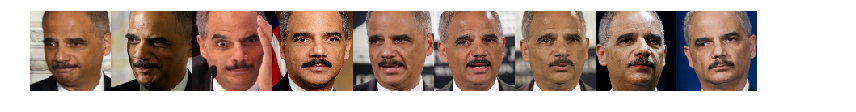

In [12]:
if FACE_REFERENCES is None:
    raise ValueError('Missing initial reference images')
show_reference_imgs(FACE_REFERENCES)

# Now we will build a training set

Hooray! We have our initial reference images. However, these are still too few to train a model. This section will rectify that by constructing a dataset of sufficient diversity and size to begin training.

Note: if the variables `neg_examples` and `pos_examples` are already defined, then you will be asked whether to reinitialize them.

In [13]:
try:
    NEG_EXAMPLES
    continue_yn_prompt('neg_examples will be overwritten')
    NEG_EXAMPLES = set()
except NameError: 
    NEG_EXAMPLES = set()

In [14]:
try:
    POS_EXAMPLES
    continue_yn_prompt('pos_examples will be overwritten')
    POS_EXAMPLES = set(FACE_REFERENCES.ids)
except NameError: 
    POS_EXAMPLES = set(FACE_REFERENCES.ids)

## Getting negative examples (via sampling)

We will obtain negative examples by randomly sampling the dataset. You will also be presented with the opportunity to clean these sampled faces. 

<b>Cleaning:</b> Faces on TV news do not receive equal screen time. Political figures such as Donald Trump and Hillary Clinton can comprise up to 2% of the total faces in the dataset. This is sufficient to appear when performing negative sampling. `get_negative_samples()` allows you to select these faces that are the target person, remove them from the negative samples, and add them them to positive examples set. 

<b>Keys:</b>
- To select a single face, hover and press '\['. 
- To select an entire page of faces, press '\{' (i.e. 'shift + ['). 

<b>Hit the "confirm selections" button when done.</b>

You can rerun `get_negative_samples()` as many times as needed.

In [15]:
get_negative_samples(FACE_REFERENCES, k=10000)

You selected 7 and ignored 0 faces.
Added 9993 negative samples and 7 positive examples of Eric Holder. There are now a total of 9993 negative examples.

Estimated true positive count: 275593 +/- 190900


## Getting positive examples (via k-NN)

To obtain an initial set of positive examples, we use the reference images that you selected earlier and find the k-nearest neighbors in the dataset. `get_positive_examples()` will sample these face ids and load a widget to confirm these positive examples.

The goal is to select a clean set of positive examples. The widget will display faces in order of ascending distance from the reference images. 

<b>Keys:</b>
- Select faces with '[' (press '{' to select a page).
- Ignore faces with ']' (press '}' to ignore a page). This will add to the negative set.
- Select <b>ALL</b> unselected or unignored faces up to an index by pressing '?' (shift + '/')
    
<b>If NO selections are made, then ALL of the faces are accepted. Hit the confirm button when done.</b>

You can rerun `get_positive_examples()` as many times as needed.

In [16]:
get_positive_examples(FACE_REFERENCES, k=10000)

Added 10000 examples of "Eric Holder" and 0 non-examples. There are now 10007 positive examples.


# Training a Classifier

This section will train a model based on examples that you selected previously. Before proceeding, make sure that you have run the negative sampling cell above and generated a set of initial positive examples If you have not, then the following cell with throw a ValueError telling you to do so.

In [ ]:
POS_LABEL = 1
NEG_LABEL = 0

####
# DEBUG PLOTS
####

def plot_score_histogram(predictions, sample, x_min=None):
    bins = np.linspace(0, 1, 100)
    plt.figure()
    plt.hist([s for _, s in predictions], bins, alpha=1)
    plt.title('Predicted Score Distribution (total: {})'.format(
              len(predictions) * sample))
    plt.xlabel('Predicted Score')
    plt.xticks(np.arange(11) / 10)
    if x_min is not None:
        plt.xlim(left=x_min)
    plt.yscale('log', nonposy='clip')
    plt.show()
    
def plot_estimated_cdf(predictions, sample, x_min=None):
    n_bins = 100
    def score_to_bin(s):
        v = math.ceil(s * n_bins)
        return min(v, n_bins)
    bins = np.zeros(n_bins + 1)
    for _, s in predictions:
        bins[score_to_bin(s)] += s

    sample_est_pos = np.sum(bins)
    total_est_pos = int(sample_est_pos) * sample
    
    norm_bins = bins / sample_est_pos
    cdf_bins = np.cumsum(norm_bins)
    inds = np.arange(bins.size) / n_bins
    plt.figure()
    plt.title('CDF of Positive Predictions ' +
              '(total estimated positives={})'.format(
              total_est_pos))
    plt.plot(inds, cdf_bins, label='Est. Cumulative Proportion')
    plt.plot(inds, norm_bins, label='Est. Bin Proportion ({} bins)'.format(n_bins))
    plt.ylabel('Proportion')
    plt.xlabel('Predicted Score')
    plt.ylim(bottom=0)
    plt.xticks(np.arange(11) / 10)
    if x_min is not None:
        plt.xlim(left=x_min)
    plt.legend()
    plt.show()
    
    print('Est. Positives by Threshold')
    total_est_bins = bins * sample
    total_est_cdf_thresh = np.cumsum(total_est_bins[::-1])
    num_thesh = 10
    for i in range(num_thesh):
        t = 1. - 0.1 * (i + 1)
        print('  t={:0.1f}\t{:0.1f}'.format(
              t, total_est_cdf_thresh[num_thesh * (i + 1) - 1]))

def sanity_check(predictions, sample_size=10000, decision_threshold=0.5):
    print('Sampling up to {} positive predictions for validation...'.format(sample_size))
    
    score_min_idx = bsearch_gte(predictions, decision_threshold, key=lambda x: x[1])
    filtered_pred = random.sample(predictions[score_min_idx:], 
                                  min(sample_size, len(predictions) - score_min_idx))
    filtered_ids = [x for x, _ in filtered_pred]
    
    sql_start_time = time.time()
    face_genders = [
        {
            'gender': f['gender__name'],
            'channel': f['face__frame__video__channel__name'],
            'show': f['face__frame__video__show__canonical_show__name'],
            'time': f['face__frame__video__time'], 
            'video_fps': f['face__frame__video__fps'],
            'frame_number': f['face__frame__number'],
            'is_three_years': f['face__frame__video__threeyears_dataset']
        } for f in FaceGender.objects.filter(
            labeler__name='knn-gender', 
            face__id__in=filtered_ids, 
            face__frame__video__time__year__gt=2008
        ).values(
            'gender__name', 'face__frame__number',
            'face__frame__video__channel__name', 
            'face__frame__video__show__canonical_show__name',
            'face__frame__video__time',
            'face__frame__video__fps',
            'face__frame__video__threeyears_dataset'
        )
    ]
    face_identities = [
        f['identity__name'] for f in FaceIdentity.objects.filter(
            labeler__name__contains='face-identity:',
            face__id__in=filtered_ids, probability__gt=0.5,
            face__frame__video__time__year__gt=2008
        ).values('identity__name')
    ]
    print('SQL query time: {:0.2f}s'.format(time.time() - sql_start_time))

    def print_gender_ratio():
        male_count = sum(1 for f in face_genders if f['gender'] == 'M')
        male_prop = male_count / len(face_genders)
        n = len(face_genders) + 2
        p_smooth = (male_count + 1) / n
        conf_prop = 1.96 * math.sqrt(p_smooth * (1 - p_smooth) / n)
        print('\nGender: {:0.1f}% male, {:0.1f}% female (+/- {:0.2f}%)'.format(
            male_prop * 100, (1 - male_prop) * 100, conf_prop * 100
        ))
    print_gender_ratio()
    
    def print_channel():
        counts = Counter(f['channel'] for f in face_genders)
        total = sum(counts[c] for c in counts.keys())
        print('\nChannel:')
        for c in sorted(counts.keys()):
            p = counts[c] / total
            print('  {}: {:0.1f}% +/- {:0.2f}% [{} faces]'.format(
                c, p * 100,
                1.96 * math.sqrt(p * (1 - p) / total) * 100,
                counts[c]
            ))
    print_channel()
    
    def print_show(n=5):
        counts = Counter(f['show'] for f in face_genders)
        total = sum(counts[c] for c in counts.keys())
        print('\nShows (top-{}):'.format(n))
        for s, c in counts.most_common(n):
            p = c / total
            print('  {}: {:0.1f}% +/- {:0.2f}%'.format(
                s, p * 100, 
                1.96 * math.sqrt(p * (1 - p) / total) * 100
            ))
    print_show()
    
    def plot_timeline():
        # TODO: move this check into the database
        def is_uniformly_sampled(f):
            if f['is_three_years']:
                return f['frame_number'] % math.floor(f['video_fps'] * 3) == 0
            else:
                return f['frame_number'] % math.ceil(f['video_fps'] * 3) == 0
        month_counts = Counter(
            date(year=f['time'].year, month=f['time'].month, day=1) 
            for f in filter(is_uniformly_sampled, face_genders))
        total = sum(month_counts[m] for m in month_counts.keys())
        month_pcts = {m: month_counts[m] / total * 100 for m in month_counts.keys()}
        
        print('\nDistribution across time (months):')
        x = [m for m in sorted(month_pcts.keys())]
        y = [month_pcts[m] for m in x]
        plt.figure(figsize=(12, 3))
        plt.scatter(x, y, color='black')
        plt.ylabel('% of faces')
        plt.show()
    plot_timeline()
    
    def print_overlapping_idents(n=10):
        if len(face_identities) > 0:
            counts = Counter(face_identities)
            print('\nPeople (top-{}):'.format(n))
            for i, c in counts.most_common(n):
                p = c / len(filtered_ids)
                print('  {}: {:0.2f}% +/- {:0.2f}%'.format(
                    i, p * 100, 
                    1.96 * math.sqrt(p * (1 - p) / len(filtered_ids)) * 100
                ))
        else:
            print('\nNo significant overlap with existing identities.')
    print_overlapping_idents()

####
# MODEL TRAINING
####
    
def train_model(params, pos_examples, neg_examples, train_val_ratio=10, min_thresh=0.05):
    print('Training logistic classifier with {}:1 train to validation split'.format(
          train_val_ratio))
    
    print('Hyperparameters')
    print('  Epochs:', params['num_epochs'])
    print('  Learning rate:', params['learning_rate'])
    print('  L2 penalty:', params['l2_penalty'])

    start_time = time.time()
    
    pos_examples_copy = list(pos_examples)
    random.shuffle(pos_examples_copy)
    pos_split_idx = int(len(pos_examples_copy) / train_val_ratio)
    val_pos, train_pos = split_list(pos_examples_copy, pos_split_idx)
    
    neg_examples_copy = list(neg_examples)
    random.shuffle(neg_examples_copy)
    neg_split_idx = int(len(neg_examples_copy) / train_val_ratio)
    val_neg, train_neg = split_list(neg_examples_copy, neg_split_idx)
    
    train_ids = train_pos + train_neg
    train_y = ([POS_LABEL] * len(train_pos)) + ([NEG_LABEL] * len(train_neg))
    
    val_ids = val_pos + val_neg
    val_y = ([POS_LABEL] * len(val_pos)) + ([NEG_LABEL] * len(val_neg))
    
    weights = face_embeddings.logreg(train_ids, train_y, **params)
    predictions = face_embeddings.logreg_predict(
        weights, min_thresh=min_thresh, sample=embedding_sample())
    
    model_time = time.time()
    print('Trained model and obtained predictions: {:0.4f}s'.format(model_time - start_time))
    
    train_id_to_idx = {v: i for i, v in enumerate(train_ids)}
    train_pred_y = [0] * len(train_ids)
    val_id_to_idx = {v: i for i, v in enumerate(val_ids)}
    val_pred_y = [0] * len(val_ids)
    
    for v, s in predictions:
        if v in train_id_to_idx:
            train_pred_y[train_id_to_idx[v]] = s
        if v in val_id_to_idx:
            val_pred_y[val_id_to_idx[v]] = s

    x_min = params.get('min_thresh', None)
    if x_min is not None:
        print('Minimum score threshold: {}'.format(x_min))
    plot_score_histogram(predictions, sample=embedding_sample(), x_min=x_min)
    print('If we interpret the scores produced by the model as probabilities, '
          'we can estimate the number of true positives that we expect to find '
          'in the dataset. The following plot makes this assumption and shows '
          'the expected contribution of faces of varying scores to the total.')
    plot_estimated_cdf(predictions, sample=embedding_sample(), x_min=x_min)
    
    print()
    sanity_check(predictions)
    return weights, predictions

####
# VISUALIZATION CONTROLS
####

GENDER_OPTIONS = {
    'disabled': 0,
    'male': 1,
    'female': 2,
}

MAX_HEIGHT = 1.
MIN_HEIGHT = 0.

MAX_SHARPNESS = 1000.
MIN_SHARPNESS = 0.

def display_filter_controls():
    
    sample_size_text = widgets.BoundedIntText(
        style=WIDGET_STYLE_ARGS,
        value=100,
        min=1,
        max=10000,
        description='Sample size:',
        disabled=False
    )

    hide_already_labeled_checkbox = widgets.Checkbox(
        style=WIDGET_STYLE_ARGS,
        value=True,
        description='Hide already labeled examples',
        disabled=False
    )

    sample_sort_button = widgets.ToggleButtons(
        style=WIDGET_STYLE_ARGS,
        options=['random', 'descending distance', 'ascending distance'],
        value='descending distance',
        description='Sample sort:',
        disabled=False,
        orientation='horizontal'
    )

    score_range_slider = widgets.FloatRangeSlider(
        layout=widgets.Layout(width='100%'),
        style=WIDGET_STYLE_ARGS,
        value=[0.45, 0.55],
        min=0,
        max=1,
        step=0.05,
        description='Predicted scores:',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='.2f',
    )

    commercial_filter_button = widgets.ToggleButtons(
        style=WIDGET_STYLE_ARGS,
        options=['disabled', 'select', 'exclude'],
        value='disabled',
        description='Commercial filter:',
        disabled=False,
        orientation='horizontal'
    )
    
    gender_filter_button = widgets.ToggleButtons(
        style=WIDGET_STYLE_ARGS,
        options=['disabled', 'male', 'female'],
        value='disabled',
        description='Gender filter:',
        disabled=False,
        orientation='horizontal'
    )

    face_height_slider = widgets.FloatRangeSlider(
        layout=widgets.Layout(width='100%'),
        style=WIDGET_STYLE_ARGS,
        value=[MIN_HEIGHT, MAX_HEIGHT],
        min=0,
        max=1,
        step=0.01,
        description='Face height (proportion):',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='.2f',
    )
    
    face_sharpness_slider = widgets.FloatRangeSlider(
        layout=widgets.Layout(width='100%'),
        style=WIDGET_STYLE_ARGS,
        value=[MIN_SHARPNESS, MAX_SHARPNESS],
        min=MIN_SHARPNESS,
        max=MAX_SHARPNESS,
        step=0.5,
        description='Face sharpness:',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='.1f',
    )

    caption_filter_button = widgets.ToggleButtons(
        style=WIDGET_STYLE_ARGS,
        options=['disabled', 'mentioned', 'not mentioned'],
        value='disabled',
        description='Captions filter:',
        disabled=False,
        orientation='horizontal'
    )

    caption_filter_text = widgets.Text(
        layout=widgets.Layout(width='100%'),
        style=WIDGET_STYLE_ARGS,
        value=FACE_REFERENCES.name,
        placeholder='Type something...',
        description='Caption phrases (separated by commas):',
        disabled=False
    )

    channel_filter_button = widgets.ToggleButtons(
        style=WIDGET_STYLE_ARGS,
        options=['disabled', 'CNN', 'FOXNEWS', 'MSNBC'],
        value='disabled',
        description='Channel filter:',
        disabled=False,
        orientation='horizontal'
    )

    canonical_show_dropdown = widgets.Dropdown(
        layout=widgets.Layout(width='100%'),
        style=WIDGET_STYLE_ARGS,
        options=['All'] + list(sorted(MAJOR_CANONICAL_SHOWS)),
        value='All',
        description='Show filter:',
        disabled=False,
    )
    
    global slice_widgets
    slice_widgets = {
        'sample_size_text': sample_size_text,
        'hide_already_labeled_checkbox': hide_already_labeled_checkbox,
        'sample_sort_button': sample_sort_button,
        'score_range_slider': score_range_slider,
        'commercial_filter_button': commercial_filter_button,
        'gender_filter_button': gender_filter_button,
        'channel_filter_button': channel_filter_button,
        'canonical_show_dropdown': canonical_show_dropdown,
        'face_height_slider': face_height_slider,
        'face_sharpness_slider': face_sharpness_slider,
        'caption_filter_button': caption_filter_button,
        'caption_filter_text': caption_filter_text
    }
    
    display(widgets.HBox([sample_size_text, hide_already_labeled_checkbox]))
    display(sample_sort_button)
    display(score_range_slider)
    display(commercial_filter_button)
    display(gender_filter_button)
    display(channel_filter_button)
    display(canonical_show_dropdown)
    display(face_height_slider)
    display(face_sharpness_slider)
    display(caption_filter_button)
    display(caption_filter_text)
    
def get_slice_args():
    global slice_widgets
    score_range = slice_widgets['score_range_slider'].value
    height_range = slice_widgets['face_height_slider'].value
    sharpness_range = slice_widgets['face_sharpness_slider'].value
    try:
        custom_filter_fn
    except NameError:
        custom_filter_fn = None
    return {
        'hide_already_labeled': slice_widgets['hide_already_labeled_checkbox'].value,
        'sample_size': slice_widgets['sample_size_text'].value,
        'sample_sort': slice_widgets['sample_sort_button'].value,
        'score_range': score_range,
        'commercial_filter': slice_widgets['commercial_filter_button'].value,
        'gender_filter': slice_widgets['gender_filter_button'].value,
        'height_range': height_range,
        'sharpness_range': sharpness_range,
        'caption_filter': slice_widgets['caption_filter_button'].value,
        'caption_text': [t.strip() for t in slice_widgets['caption_filter_text'].value.split(',')],
        'channel': slice_widgets['channel_filter_button'].value,
        'canonical_show': slice_widgets['canonical_show_dropdown'].value,
        'custom_filter_fn': custom_filter_fn
    }

MAX_DJANGO_QUERY_IDS = 50000
def django_query_filter_fn(qs, slice_args):
    if slice_args['commercial_filter'] != 'disabled':
        qs = qs.filter(
            shot__in_commercial=slice_args['commercial_filter'] == 'select')

    min_height, max_height = slice_args['height_range']
    if min_height > MIN_HEIGHT or max_height < MAX_HEIGHT:
        qs = qs.annotate(height=BoundingBox.height_expr())
        min_height = min_height
        if min_height > MIN_HEIGHT:
            qs = qs.filter(height__gte=min_height)
        max_height = max_height
        if max_height < MAX_HEIGHT:
            qs = qs.filter(height__lte=max_height)

    min_sharpness, max_sharpness = slice_args['sharpness_range']
    if min_sharpness > MIN_SHARPNESS:
        qs = qs.filter(blurriness__gte=min_sharpness)
    if max_sharpness < MAX_SHARPNESS:
        qs = qs.filter(blurriness__lte=max_sharpness)

    if slice_args['channel'] != 'disabled':
        qs = qs.filter(
            frame__video__channel__name=slice_args['channel'])
        
    if slice_args['canonical_show'] != 'All':
        qs = qs.filter(
            frame__video__show__canonical_show__name=slice_args['canonical_show'])

    if slice_args['caption_filter'] != 'disabled':
        video_ids = set()
        for phrase in slice_args['caption_text']:
            video_ids |= video_ids_with_mentions(phrase)
            video_ids |= video_ids_with_mentions(phrase.upper())
        if slice_args['caption_filter'] == 'mentioned':
            qs = qs.filter(frame__video__id__in=video_ids)
        else:
            qs = qs.exclude(frame__video__id__in=video_ids)

    # Execute custom Esper query
    if slice_args['custom_filter_fn'] is not None:
        try:
            qs = slice_args['custom_filter_fn'](qs)
        except Exception as e:
            traceback.print_exc()
    return qs

def gender_filter_fn(gender_filter, face_id):
    if gender_filter == 1:    # Male 
        return not is_female_face_id(face_id)
    elif gender_filter == 2:  # Female
        return is_female_face_id(face_id)
    else:
        return True

####
# SLICE SELECTION WIDGET
####

def visualize():
    print('Loading widget...')
    
    slice_args = get_slice_args()
    
    submit_button = widgets.Button(
        layout=widgets.Layout(width='auto'),
        style=WIDGET_STYLE_ARGS,
        description='Confirm selections',
        disabled=False,
        button_style='danger'
    )
    
    refresh_button = widgets.Button(
        layout=widgets.Layout(width='auto'),
        style=WIDGET_STYLE_ARGS,
        description='Refresh (w/o confirming)',
        disabled=False,
        button_style='',
    )
    
    dismiss_button = widgets.Button(
        layout=widgets.Layout(width='auto'),
        style=WIDGET_STYLE_ARGS,
        description='Dismiss widget',
        disabled=False,
        button_style=''
    )
    
    labeled_ids_set = POS_EXAMPLES | NEG_EXAMPLES
    
    gender_filter = GENDER_OPTIONS[slice_args['gender_filter']]
    hide_already_labeled = slice_args['hide_already_labeled']
    def pre_query_filter_fn(face_id_and_score):
        face_id, _ = face_id_and_score
        if hide_already_labeled and face_id in labeled_ids_set:
            return False
        return gender_filter_fn(gender_filter, face_id)
    
    pre_filter_start = time.time()
    min_score, max_score = slice_args['score_range']
    score_min_idx = bsearch_gte(PREDICTIONS, min_score, key=lambda x: x[1])
    score_max_idx = bsearch_gte(PREDICTIONS, max_score, key=lambda x: x[1])
    filtered_pred = list(
        filter(pre_query_filter_fn, 
               itertools.islice(PREDICTIONS, score_min_idx, score_max_idx)))
    print('Pre-filter (Python): {:0.3f}s ({} objects remain)'.format(
          time.time() - pre_filter_start, len(filtered_pred)))
    if len(filtered_pred) > MAX_DJANGO_QUERY_IDS:
        print('SQL query size exceeded {} ids. Sampling for performance reasons...'.format(
              MAX_DJANGO_QUERY_IDS), file=sys.stderr)
        filtered_pred = random.sample(filtered_pred, MAX_DJANGO_QUERY_IDS)
    
    sql_filter_start = time.time()
    filtered_pred_faces = query_faces([x[0] for x in filtered_pred])
    filtered_pred_faces = django_query_filter_fn(filtered_pred_faces, slice_args)
    filtered_count = filtered_pred_faces.count()
    sample_size = slice_args['sample_size']
    if filtered_count > sample_size:
        filtered_pred_faces = query_sample(filtered_pred_faces, sample_size)
    filtered_pred_faces = list(filtered_pred_faces)
    print('Filter + Materialize (SQL): {:0.3f}s'.format(
          time.time() - sql_filter_start))
    
    print('Showing {} of {} faces'.format(
          min(sample_size, filtered_count), filtered_count))
    
    # Reorder the samples
    if slice_args['sample_sort'] != 'disabled':
        filtered_pred_faces = sort_faces_by_distance(
            filtered_pred_faces, FACE_REFERENCES.embs,
            'ascending' in slice_args['sample_sort'])

    selection_widget = esper_widget(
        query_faces_result(filtered_pred_faces), disable_playback=True,
        crop_bboxes=True, jupyter_keybindings=True, results_per_page=faces_per_page(),
        disable_captions=True, show_inline_metadata=False
    )
    
    def on_submit(b):
        selected_idxs = set(selection_widget.selected)
        ignored_idxs = set(selection_widget.ignored)
        clear_output()
        
        selected_face_ids = []
        ignored_face_ids = []
        for i, f in enumerate(filtered_pred_faces):
            if i in selected_idxs:
                selected_face_ids.append(f['id'])
            if i in ignored_idxs:
                ignored_face_ids.append(f['id'])

        new_pos_labels = 0
        for i in selected_face_ids:
            if i not in labeled_ids_set:
                POS_EXAMPLES.add(i)
                new_pos_labels += 1
        new_neg_labels = 0
        for i in ignored_face_ids:
            if i not in labeled_ids_set:
                NEG_EXAMPLES.add(i)
                new_neg_labels += 1
                
        print('Added {} new positive and {} new negative examples'.format(
              new_pos_labels, new_neg_labels))
        print('Dismissed widget. Rerun the cell to get it back.')
    submit_button.on_click(on_submit)
        
    def on_refresh(b):
        clear_output()
        print('Refreshed without updating examples')
        visualize()
    refresh_button.on_click(on_refresh)
    
    def on_dismiss(b):
        clear_output()
        print('Dismissed widget. Rerun the cell to get it back.')
    dismiss_button.on_click(on_dismiss)
    
    display(widgets.HBox(
        [widgets.Label('Controls:'), submit_button, refresh_button, dismiss_button]))
    print(('Highlight in yellow faces (use \'[\' key) that are {} and '
           'highlight in red faces (\']\' key) that are not.').format(
          FACE_REFERENCES.name))
    display(selection_widget)
    
####
# VAIDATION AND DEBUGING WIDGETS
####

def charts(min_score=0.2):
    print('Loading charts for slice... Note: for efficiency, min_score={}'.format(min_score))

    slice_args = get_slice_args()
    
    refresh_button = widgets.Button(
        layout=widgets.Layout(width='auto'),
        style=WIDGET_STYLE_ARGS,
        description='Refresh',
        disabled=False,
        button_style='info',
        tooltip='Refresh examples'
    )
    def on_refresh(b):
        clear_output()
        charts(min_score)
    refresh_button.on_click(on_refresh)
    
    dismiss_button = widgets.Button(
        layout=widgets.Layout(width='auto'),
        style=WIDGET_STYLE_ARGS,
        description='Dismiss widget',
        disabled=False,
        button_style='',
        tooltip='Dismiss widget'
    )
    def on_dismiss(b):
        clear_output()
        print('Dismissed charts. Rerun the cell to get them back.')
    dismiss_button.on_click(on_dismiss)
    
    gender_filter = GENDER_OPTIONS[slice_args['gender_filter']]
    
    display(widgets.HBox([
        widgets.Label('Controls:'), refresh_button, dismiss_button]))

    print('Computing prediction distibution for slice')
    def pre_query_filter_fn(face_id_and_score):
        face_id, _ = face_id_and_score
        return gender_filter_fn(gender_filter, face_id)

    score_min_idx = bsearch_gte(PREDICTIONS, min_score, 
                                key=lambda x: x[1])
    slice_pred = list(filter(pre_query_filter_fn, itertools.islice(
        PREDICTIONS, score_min_idx, len(PREDICTIONS))))
    slice_pred_faces = Face.objects.filter(id__in=[x[0] for x in slice_pred])
    slice_pred_faces = django_query_filter_fn(slice_pred_faces, slice_args)

    # Filter predictions
    slice_pred_face_ids = {f['id'] for f in slice_pred_faces.values('id')}
    slice_pred = list(filter(lambda x: x[0] in slice_pred_face_ids, slice_pred))

    print('Face count: {}'.format(len(slice_pred_face_ids)))
    plot_score_histogram(slice_pred, sample=embedding_sample(), x_min=min_score)
    plot_estimated_cdf(slice_pred, sample=embedding_sample(), x_min=min_score)
      
def precision(sample_size=None, decision_threshold=0.5):
    print('Loading widget...')
    
    submit_button = widgets.Button(
        layout=widgets.Layout(width='auto'),
        style=WIDGET_STYLE_ARGS,
        description='Compute precison',
        disabled=False,
        button_style='danger'
    )
    
    dismiss_button = widgets.Button(
        layout=widgets.Layout(width='auto'),
        style=WIDGET_STYLE_ARGS,
        description='Dismiss widget',
        disabled=False,
        button_style=''
    )
    
    if sample_size is None:
        sample_size = faces_per_page()
    
    score_min_idx = bsearch_gte(PREDICTIONS, decision_threshold, key=lambda x: x[1])
    filtered_pred = random.sample(PREDICTIONS[score_min_idx:], sample_size)
    filtered_pred_faces = query_faces([x[0] for x in filtered_pred])
    
    print('Showing {} faces.'.format(len(filtered_pred_faces)))
    
    selection_widget = esper_widget(
        query_faces_result(filtered_pred_faces), disable_playback=True,
        crop_bboxes=True, jupyter_keybindings=True, results_per_page=faces_per_page(),
        disable_captions=True)
    
    def on_submit(b):
        ignored_idxs = set(selection_widget.ignored)
        clear_output()
        
        not_ignored_face_ids = []
        ignored_face_ids = []
        for i, f in enumerate(filtered_pred_faces):
            if i in ignored_idxs:
                ignored_face_ids.append(f['id'])
            else:
                not_ignored_face_ids.append(f['id'])
        
        sample_precision = len(not_ignored_face_ids) / len(filtered_pred_faces)
        sample_precision_smoothed = (len(not_ignored_face_ids) + 1) / (len(filtered_pred_faces) + 2)
        print('Est. precision: {:0.2f} +/- {:0.2f}'.format(
            sample_precision,
            1.96 * math.sqrt(sample_precision_smoothed * 
                             (1 - sample_precision_smoothed) / (len(filtered_pred_faces) + 2))
        ))
        
        labeled_ids_set = POS_EXAMPLES | NEG_EXAMPLES
        
        new_pos_labels = 0
        for i in not_ignored_face_ids:
            if i not in labeled_ids_set:
                POS_EXAMPLES.add(i)
                new_pos_labels += 1
        new_neg_labels = 0
        for i in ignored_face_ids:
            if i not in labeled_ids_set:
                NEG_EXAMPLES.add(i)
                new_neg_labels += 1
                
        print('Added {} new positive and {} new negative examples'.format(
              new_pos_labels, new_neg_labels))
    submit_button.on_click(on_submit)
    
    def on_dismiss(b):
        clear_output()
        print('Dismissed widget. Rerun the cell to get it back.')
    dismiss_button.on_click(on_dismiss)
    
    display(widgets.HBox(
        [widgets.Label('Controls:'), submit_button, dismiss_button]))
    print(('Highlight in red faces (use \']\' key) that are not {}.').format(
          FACE_REFERENCES.name))
    display(selection_widget)

def show_dataset():
    refresh_button = widgets.Button(
        layout=widgets.Layout(width='auto'),
        style=WIDGET_STYLE_ARGS,
        description='Refresh',
        disabled=False,
        button_style='info',
        tooltip='Refresh examples'
    )
    def on_refresh(b):
        clear_output()
        show_dataset()
    refresh_button.on_click(on_refresh)
    
    dismiss_button = widgets.Button(
        layout=widgets.Layout(width='auto'),
        style=WIDGET_STYLE_ARGS,
        description='Dismiss widget',
        disabled=False,
        button_style='',
        tooltip='Dismiss widget'
    )
    def on_dismiss(b):
        clear_output()
        print('Dismissed widgets. Rerun the cell to get them back.')
    dismiss_button.on_click(on_dismiss)
    
    num_tabs = 2
    outputs = [widgets.Output() for _ in range(num_tabs)]
    tabs = widgets.Accordion(children=outputs)
    tabs.set_title(0, 'Positive Training Examples')
    tabs.set_title(1, 'Negative Training Examples')
    
    display(widgets.HBox([
        widgets.Label('Controls:'), refresh_button, dismiss_button]))
    display(tabs)
        
    with outputs[0]:
        def show_pos_train_faces():
            print('Showing positive training examples from slice. Faces least similar to "{}" are shown first.'.format(
                FACE_REFERENCES.name))
            pos_faces = query_faces(POS_EXAMPLES)
            pos_faces = sort_faces_by_distance(
                list(pos_faces), FACE_REFERENCES.embs, ascending=False)
            pos_train_widget = esper_widget(
                query_faces_result(pos_faces), disable_playback=True,
                crop_bboxes=True, jupyter_keybindings=True, 
                results_per_page=faces_per_page(), disable_captions=True)

            submit_pos_button = widgets.Button(
                layout=widgets.Layout(width='auto'),
                style=WIDGET_STYLE_ARGS,
                description='Commit selections',
                disabled=False,
                button_style='danger',
            )
            def on_pos_submit(b):
                ignored_idxs = set(pos_train_widget.ignored)
                ignored_ids = {
                    f['id'] for i, f in enumerate(pos_faces) if i in ignored_idxs
                }
                global POS_EXAMPLES, NEG_EXAMPLES
                POS_EXAMPLES = POS_EXAMPLES - ignored_ids
                NEG_EXAMPLES = NEG_EXAMPLES | ignored_ids
                clear_output()
                print(('Removed {} faces from the positive set '
                       'and added them to the negative set.').format(
                       len(ignored_ids)))
                show_pos_train_faces()
            submit_pos_button.on_click(on_pos_submit)
            
            print('Loading widget...')
            display(submit_pos_button)
            display(pos_train_widget)
        show_pos_train_faces()
        
    with outputs[1]:
        def show_neg_train_faces():
            print('Showing negative training examples from slice. Faces most similar to "{}" are shown first.'.format(
                FACE_REFERENCES.name))
            neg_faces = query_faces(NEG_EXAMPLES)
            neg_faces = sort_faces_by_distance(
                list(neg_faces), FACE_REFERENCES.embs, ascending=True)
            neg_train_widget = esper_widget(
                query_faces_result(neg_faces), disable_playback=True,
                crop_bboxes=True, jupyter_keybindings=True, disable_captions=True,
                results_per_page=faces_per_page())

            submit_neg_button = widgets.Button(
                layout=widgets.Layout(width='auto'),
                style=WIDGET_STYLE_ARGS,
                description='Commit selections',
                disabled=False,
                button_style='danger',
            )
            def on_neg_submit(b):
                selected_idxs = set(neg_train_widget.selected)
                selected_ids = {
                    f['id'] for i, f in enumerate(neg_faces) if i in selected_idxs
                }
                global POS_EXAMPLES, NEG_EXAMPLES
                POS_EXAMPLES = POS_EXAMPLES | selected_ids
                NEG_EXAMPLES = NEG_EXAMPLES - selected_ids
                clear_output()
                print(('Removed {} faces from the negative set '
                       'and added them to the positive set.').format(
                      len(selected_ids)))
                show_neg_train_faces()
            submit_neg_button.on_click(on_neg_submit)
            
            print('Loading widget...')
            display(submit_neg_button)
            display(neg_train_widget)
        show_neg_train_faces()
        
print('Initialization cell ran successfully. Loaded ML and visualization libraries.')

In [18]:
if POS_EXAMPLES is None:
    raise ValueError('No positive training examples! Did you confirm the selection above?')
if NEG_EXAMPLES is None:
    raise ValueError('No negative training examples!')
print('Proceeding with {} positive and {} negative training examples'.format(len(POS_EXAMPLES), len(NEG_EXAMPLES)))

Proceeding with 10007 positive and 9993 negative training examples


## Training and obtaining predictions across the dataset

`train_model()` will train a binary classifier using the face identifiers in `pos_examples` and `neg_examples`. This will take roughly 20 seconds. Each time you rerun `train_model()`, your model will be retrained, so be sure to rerun it when you have added new labels and are ready to retrain. This will also generate some debugging charts to diagnose model performance.

Training logistic classifier with 10:1 train to validation split
Hyperparameters
  Epochs: 40
  Learning rate: 1
  L2 penalty: 1e-05
Trained model and obtained predictions: 4.5914s


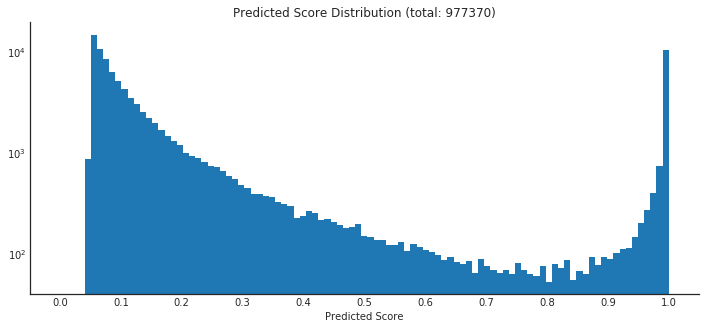

If we interpret the scores produced by the model as probabilities, we can estimate the number of true positives that we expect to find in the dataset. The following plot makes this assumption and shows the expected contribution of faces of varying scores to the total.


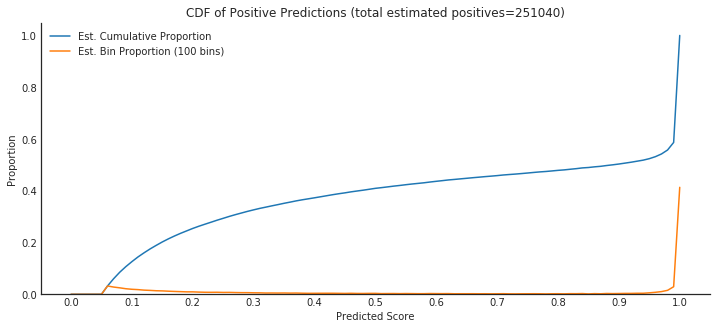

Est. Positives by Threshold
  t=0.9	124702.0
  t=0.8	130847.4
  t=0.7	135941.9
  t=0.6	141463.3
  t=0.5	148279.2
  t=0.4	157464.3
  t=0.3	169151.7
  t=0.2	187169.9
  t=0.1	219381.3
  t=0.0	251046.0

Sampling up to 10000 positive predictions for validation...
SQL query time: 35.43s

Gender: 99.8% male, 0.2% female (+/- 0.09%)

Channel:
  CNN: 18.9% +/- 0.77% [1894 faces]
  FOXNEWS: 49.1% +/- 0.98% [4909 faces]
  MSNBC: 31.9% +/- 0.91% [3193 faces]

Shows (top-5):
  CNN Newsroom: 5.6% +/- 0.45%
  The OReilly Factor: 5.5% +/- 0.45%
  America Live: 5.0% +/- 0.43%
  The Rachel Maddow Show: 4.9% +/- 0.42%
  Americas Newsroom: 4.4% +/- 0.40%

Distribution across time (months):


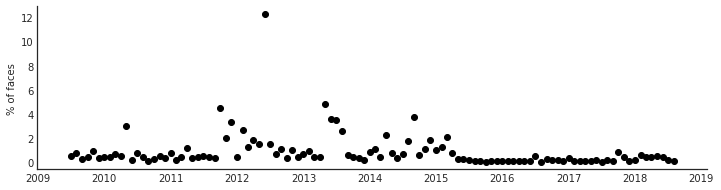


People (top-10):
  barack obama: 5.20% +/- 0.44%
  bill hemmer: 0.03% +/- 0.03%
  geraldo rivera: 0.02% +/- 0.03%
  john stossel: 0.02% +/- 0.03%
  john kelly: 0.01% +/- 0.02%


In [23]:
params = {
    'num_epochs': 40,
    'learning_rate': 1,
    'l2_penalty': 1e-5
}
WEIGHTS, PREDICTIONS = train_model(params, POS_EXAMPLES, NEG_EXAMPLES)

## Visualize predictions and label new examples

Your reference images for Eric Holder.


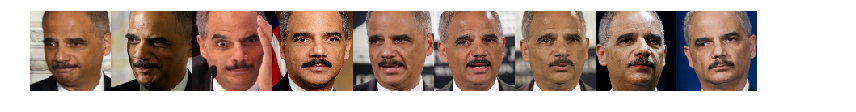

ToggleButtons(description='Sample sort:', index=1, options=('random', 'descending distance', 'ascending distan…

FloatRangeSlider(value=(0.45, 0.55), continuous_update=False, description='Predicted scores:', layout=Layout(w…

ToggleButtons(description='Commercial filter:', options=('disabled', 'select', 'exclude'), style=ToggleButtons…

ToggleButtons(description='Gender filter:', options=('disabled', 'male', 'female'), style=ToggleButtonsStyle(d…

ToggleButtons(description='Channel filter:', options=('disabled', 'CNN', 'FOXNEWS', 'MSNBC'), style=ToggleButt…

Dropdown(description='Show filter:', layout=Layout(width='100%'), options=('All', 'AM Joy', 'AM Wake Up Call',…

FloatRangeSlider(value=(0.0, 1.0), continuous_update=False, description='Face height (proportion):', layout=La…

FloatRangeSlider(value=(0.0, 1000.0), continuous_update=False, description='Face sharpness:', layout=Layout(wi…

ToggleButtons(description='Captions filter:', options=('disabled', 'mentioned', 'not mentioned'), style=Toggle…

Text(value='Eric Holder', description='Caption phrases (separated by commas):', layout=Layout(width='100%'), p…

In [20]:
show_reference_imgs(FACE_REFERENCES)
display_filter_controls()

You may also define a custom query filter function using any of the Esper models. Note that the cell below will need to be re-run each time the function is updated. <b>(Note: the cell is hidden. Unhide it to write custom code.)</b>

In [ ]:
def custom_filter_fn(qs):
    # BEGIN: INSERT CODE HERE
    print('No custom filter defined.', file=sys.stderr)
    # END
    return qs

The labeling widget will display below once `visualize()` is called. If you update the selections and sliders above, you can reload the visualization by confirming your current labels by hitting the <b>Confirm selections</b> button or by hitting the <b>Refresh</b> button. Alternatively, rerun the cell.

<b>Keys:</b>
 - To label a positive face, press '['. To label all faces on a page, press '{' (i.e., shift + '[').
 - To label a negative face, press ']'. To label all faces on a page, press '}' (i.e., shift + ']').
 - To expand an image, press '=', and press again to shrink it.
 - To label ALL previously unlabeled faces up to and including the current face as positive, press '?' (i.e., shift + '/').

In [22]:
visualize()

Added 27 new positive and 23 new negative examples
Dismissed widget. Rerun the cell to get it back.


## Check model precision

The following cell evaluates the precision of the model by randomly sampling faces with scores over 0.5. Select the faces that are the target person.

In [ ]:
precision()

# Your current dataset

`show_dataset()` lets you examine all of the labels that you have assigned so far for the current identity. You can use the following set to edit your previously applied labels.

Possible actions:
- You can select `[` faces that are of the target person.
- You can deselect `]` faces that are not of the target person.

In [ ]:
show_dataset()

# Saving your model

Serialize the model weights and the training set. Store the file locally and in Google Cloud Storage.

In [ ]:
save_model_and_examples(path=None)

# Reset Notebook

In [ ]:
reset_notebook()